# Vorhersage von Festgeldanlagen

Einleitung: In dieser Analyse wird beispielhaft untersucht, ob anhand der bestehenden Daten Kundensegmente identifiziert werden können, die sich für eine zukünftige Marketingsstrategie von Festgeldanlagen eignen. Zur Datenaufbereitung wird eine One-Hot- & Dummy-Kodierung verwendet. Im Abschnitt der Datenanalyse wird eine logistische Regression & ein Random-Forest Modell verwendet, um Wahrscheinlichkeiten für bestimmte Kundensegmente zu bestimmen. Danach wird die Vorhersagequalität des Modells überprüft und es wird bewertet, ob das Modell besser als zufällig eine Festgeldanlage bestimmen kann.

##### Inhaltsverzeichnis:
##### 1. Problemstellung
- Relevanz für die Vermarktung von Produkten
##### 2. Datenaufbereitung
- One-Hot- & Dummy-Kodierung relevanter demographischer Merkmale
- Fehlende & nicht-aussagkräftige Werte werden dekodiert
##### 3. Datenanalyse
- Logistische Regression & Random-Forest Modell
##### 4. Modellevaluation
- Bestimmung des optimalen Threshold und Bewertung der Vorhersagewahrscheinlichkeit
- Cross-Validated ROC & Test-ROC im Verglech
##### 5. Interpretation

### 1. Problemstellung

Banken verfügen über umfangreiche Kundendaten, nutzen diese jedoch häufig nicht systematisch zur gezielten Produktansprache. Die zentrale Problemstellung besteht darin, auf Basis vorhandener Kundendaten jene Kunden bzw. Kundensegmente zu identifizieren, die mit hoher Wahrscheinlichkeit eine Festgeldanlage abschließen. Daher sollen bestimmte Kundensegment identifiziert werden, um den Absatz zinstragender Produkte zu erhöhen und die Vermarktungsressourcen zu optimieren.

Forschungsfrage: Welche Kundenmerkmale beeinflussen die Wahrscheinlichkeit des Abschlusses einer Festgeldanlage und wie gut lassen sich diese mithilfe von Entscheidungsbaum-Modellen prognostizieren?

---

### 2. Datenaufbereitung

##### 2.1 Datensatz wird geladen

In [1]:
import pandas as pd 
df = pd.read_csv("bank-additional-full.csv", sep=";") ## Datensatz laden
df.head(1000)

<ipython-input-1-e0d944a90d8b>:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("bank-additional-full.csv", sep=";") ## Datensatz laden


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,01. Jan,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,01. Jan,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,01. Jan,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,01. Jan,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,01. Jan,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,32,entrepreneur,married,basic.6y,no,yes,no,telephone,may,wed,...,1,999,0,nonexistent,01. Jan,93.994,-36.4,4.856,5191.0,no
996,41,services,single,high.school,no,yes,yes,telephone,may,wed,...,1,999,0,nonexistent,01. Jan,93.994,-36.4,4.856,5191.0,no
997,59,housemaid,married,basic.6y,no,yes,no,telephone,may,wed,...,1,999,0,nonexistent,01. Jan,93.994,-36.4,4.856,5191.0,no
998,57,technician,married,basic.9y,no,yes,no,telephone,may,wed,...,1,999,0,nonexistent,01. Jan,93.994,-36.4,4.856,5191.0,no


##### 2.2 Abhängige Variable - Festgeldanlage

Die Variable "y" gibt an, wie viele Personen im Datensatz eine Festgeldanlage abgeschlossen haben. Insgesamt haben 4640 und damit 11,27 % der Personen im Datensatz eine Festgeldanlage abgeschlossen.

In [2]:
df["y"] = (df["y"] == "yes").astype(int)

In [3]:
df["y"].value_counts()

y
0    36548
1     4640
Name: count, dtype: int64

##### 2.3 Alter in Kategorien (ohne unter 25 Jährige)

In [4]:
# Alter in Kategorien (ohne <25)
df = df[df["age"] >= 25]
df["AGE_GROUP"] = pd.cut(df["age"],
                         bins=[24, 34, 44, 54, 100],
                         labels=["25-34", "35-44", "45-54", "55+"])

##### 2.4 Beziehungsstatus ohne unknown (keine Aussagekraft)

In [5]:
df = df[df["marital"] != "unknown"]

##### 2.5 Job-Kategorien (zusammengefasst; alle unter 500 zu rare_jobs)

In [6]:
job_counts = df["job"].value_counts()
rare_jobs = job_counts[job_counts < 500].index.tolist()
df["job_mod"] = df["job"].replace(rare_jobs, "other")

##### 2.6 One-Hot Encoding und Dummy-Variablen für kategoriale und binäre Variablen

In [7]:
job_dummies = pd.get_dummies(df["job_mod"], prefix="job", drop_first=True)
mar_dummies = pd.get_dummies(df["marital"], prefix="marital", drop_first=True)
age_dummies = pd.get_dummies(df["AGE_GROUP"], prefix="AGE", drop_first=True)

In [8]:
df["housing_binary"] = (df["housing"] == "yes").astype(int)
df["loan_binary"]    = (df["loan"] == "yes").astype(int)

##### 2.7 Umwandlung in Data-Frame

In [9]:
# Finaler Feature‑DataFrame
X = pd.concat([
    job_dummies,
    mar_dummies,
    age_dummies,
    df[["housing_binary", "loan_binary"]]
], axis=1)

# Target
y = df["y"]

##### 2.8 Fehlende Werte werden dekodiert

In [10]:
data = pd.concat([y, X], axis=1).dropna()
y_clean = data["y"]
X_clean = data.drop(columns=["y"])

print("Shape von X_clean:", X_clean.shape)
print("Verteilung von y_binary:\n", y_clean.value_counts(normalize=True))

Shape von X_clean: (40040, 17)
Verteilung von y_binary:
 y
0    0.890809
1    0.109191
Name: proportion, dtype: float64


---

### 3. Datenanalyse

#### 3.1 Logistisches Regressionsmodell

In [11]:
import statsmodels.api as sm

X_model = sm.add_constant(X_clean)

# Alles in float
X_model = X_model.astype(float)
y_clean = y_clean.astype(float)

# Logit fitten
logit_model = sm.Logit(y_clean, X_model)
logit_result = logit_model.fit()
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.334833
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40040
Model:                          Logit   Df Residuals:                    40022
Method:                           MLE   Df Model:                           17
Date:                Tue, 03 Feb 2026   Pseudo R-squ.:                 0.02896
Time:                        16:54:45   Log-Likelihood:                -13407.
converged:                       True   LL-Null:                       -13807.
Covariance Type:            nonrobust   LLR p-value:                5.134e-159
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.9632      0.065    -30.209      0.000      -2.091      -1.836
job_blue

Personen, die:
- im Handwerk oder der Industrie arbeiten, haben die geringste Wahrscheinlichkeit der Festgeldanlage.
- im Ruhestand sind, haben die höchste Wahrscheinlichkeit einer Festgeldanlage.
- single sind, haben die höchste Wahrscheinlichkeit einer Festgeldanlage.
- über 55 Jahre alt sind, haben die höchste Wahrscheinlichkeit einer Festgeldanlage.

Anmerkung: Die binären Variablen "housing" und "loan" haben keine statistisch bedeutenden Differenzen ihrer Kategorien. 

----

#### 3.2 Random-Forest Modell

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Trainings- und Testdaten splitten
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.3, random_state=42, stratify=y_clean
)

# Random Forest Modell definieren
rf_model = RandomForestClassifier(
    n_estimators=500,    # Anzahl Bäume
    max_depth=None,      # unbegrenzte Tiefe, kann angepasst werden
    random_state=42,
    class_weight="balanced",
    n_jobs=-1            # parallel auf allen CPUs
)

# Fit auf Trainingsdaten
rf_model.fit(X_train, y_train)

# Vorhersagen
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

dt_model = DecisionTreeClassifier(
    max_depth=4,        # begrenzt die Tiefe für bessere Interpretierbarkeit
    min_samples_leaf=20,
    class_weight="balanced", # verhindert zu kleine Blätter
    random_state=42
)

dt_model.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [14]:
df["pd_tree"] = dt_model.predict_proba(X)[:, 1]  # Wahrscheinlichkeit für default=1

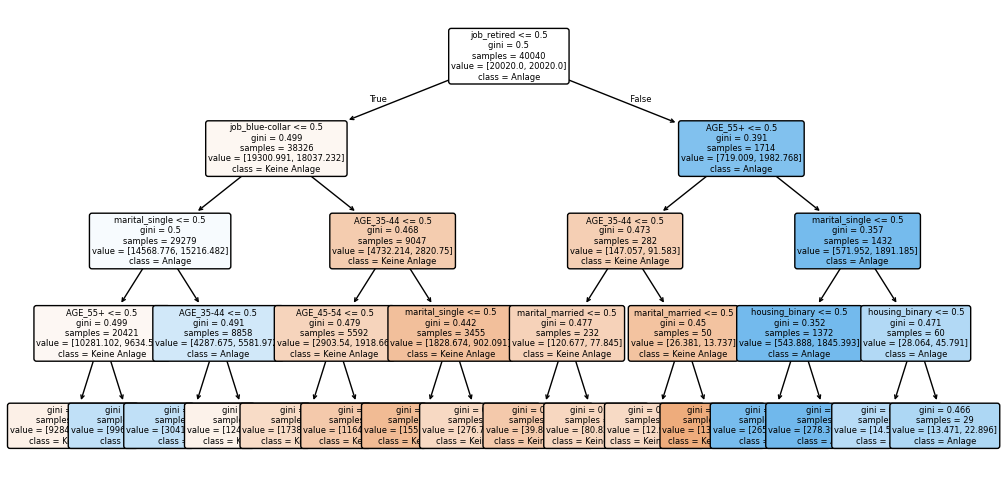

In [15]:
plt.figure(figsize=(12,6))
tree.plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=["Keine Anlage", "Anlage"],
    filled=True,
    rounded=True,
    fontsize=6
)
plt.show()

Personen, die: 
- im Ruhestand sind (job_retired = 1) → überwiegend Festgeldanlage abschließen
- nicht im Ruhestand sind (job_retired = 0) und Blue-Collar Jobs haben (job_blue-collar = 1) → überwiegend keine Festgeldanlage
- nicht Blue-Collar und Single sind → Tendenz zu keine Festgeldanlage, aber stärker abhängig vom Alter
- Alter 55+ und nicht Blue-Collar → höhere Wahrscheinlichkeit für Festgeldanlage, besonders wenn verheiratet
- junge Altersgruppen (35-44, 45-54) mit Blue-Collar Jobs → überwiegend keine Festgeldanlage
- housing_binary = 1 in Kombination mit älteren oder verheirateten Gruppen → leicht erhöhte Wahrscheinlichkeit für Festgeldanlage
- Verheiratete mittlere Altersgruppen → überwiegend keine Festgeldanlage

-----

### 4. Modellevaluation

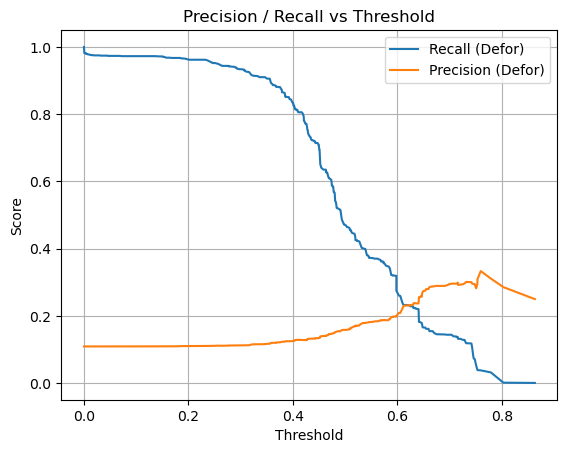

In [16]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure()
plt.plot(thresholds, recall[:-1], label="Recall (Defor)")
plt.plot(thresholds, precision[:-1], label="Precision (Defor)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision / Recall vs Threshold")
plt.grid(True)
plt.show()


Aus der oberen Grafik soll der optimale "Threshold" abgelesen werden. Daraus soll der optimale Bewertungspunkt bestimmt werden, ab dem unser Modell eine Festgeldanlage bestimmt. Für die Bewertung des Modells legen wir den Modell auf 0.45 fest, da der Recall noch relativ hoch ist und die Präzision der Vorhersage hoch ist. 

In [17]:
from sklearn.metrics import classification_report

y_pred = (y_pred_prob >= 0.45).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.45      0.61     10700
         1.0       0.13      0.69      0.23      1312

    accuracy                           0.48     12012
   macro avg       0.53      0.57      0.42     12012
weighted avg       0.84      0.48      0.57     12012



Das Modell erkennt etwa 7 von 10 Personen, die tatsächlich eine Festgeldanlage abschließen. Allerdings sagt es bei vielen Kunden fälschlicherweise einen Abschluss voraus, sodass nur ungefähr jede achte vorhergesagte Person wirklich investiert. Insgesamt eignet sich das Modell gut, um potenzielle Käufer zu finden, auch wenn dafür mehr Kunden kontaktiert werden müssen.

In [18]:
import pandas as pd

importance = pd.Series(dt_model.feature_importances_, index=X.columns)
importance.sort_values(ascending=False)

job_retired          0.370764
job_blue-collar      0.266160
AGE_55+              0.156769
marital_single       0.115622
AGE_35-44            0.081590
AGE_45-54            0.007624
marital_married      0.000764
housing_binary       0.000707
job_unemployed       0.000000
job_technician       0.000000
job_entrepreneur     0.000000
job_services         0.000000
job_self-employed    0.000000
job_other            0.000000
job_management       0.000000
job_housemaid        0.000000
loan_binary          0.000000
dtype: float64

AUC: 0.6252


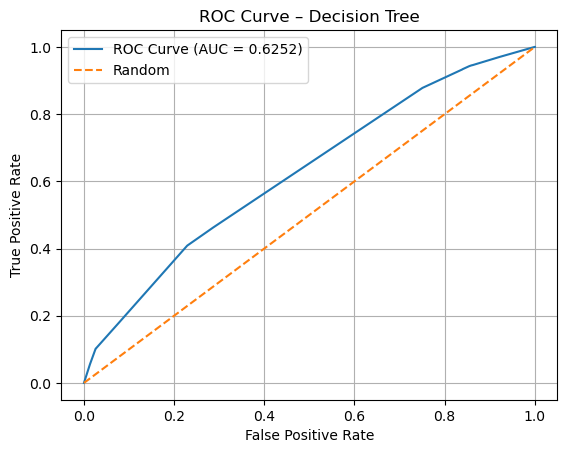

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Wahrscheinlichkeiten für die positive Klasse
y_prob = dt_model.predict_proba(X_test)[:, 1]

# AUC berechnen
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}")

# ROC-Kurve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Decision Tree")
plt.legend()
plt.grid(True)
plt.show()


Der AUC-Wert des Modells liegt bei 0.6252. Aus diesem Grund können wir sagen, dass unser Modell leicht besser als zufällig eine Festgeldanlage anhand der Trainingsdaten vorhersagen kann. Somit ist das Modell für eine Marketing-Abteilung von Festgeldanlagen brauchbar und kann Kundensegmente vorhersagen, die sich für das Produkt interessieren könnten. 

In [21]:
from sklearn.model_selection import cross_val_predict

y_proba_cv = cross_val_predict(
    dt_model, X, y, cv=5, method="predict_proba"
)[:, 1]

auc_cv = roc_auc_score(y, y_proba_cv)

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y, y_proba_cv) # ROC-Werte 
auc_cv = roc_auc_score(y, y_proba_cv) # AUC-Wert

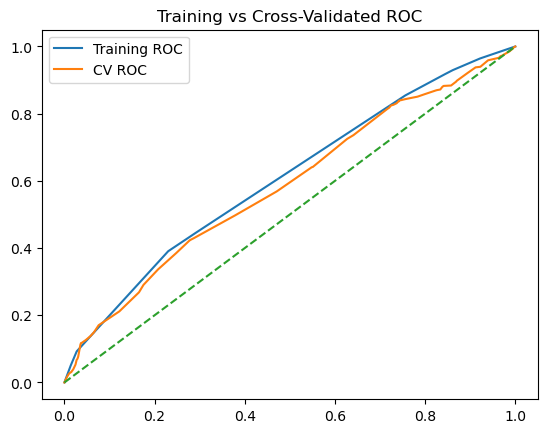

In [22]:
y_proba_train = dt_model.predict_proba(X)[:, 1]

fpr_t, tpr_t, _ = roc_curve(y, y_proba_train)
fpr_cv, tpr_cv, _ = roc_curve(y, y_proba_cv)

plt.figure()
plt.plot(fpr_t, tpr_t, label="Training ROC")
plt.plot(fpr_cv, tpr_cv, label="CV ROC")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.legend()
plt.title("Training vs Cross-Validated ROC")
plt.show()


Der Cross-Validated ROC sagt aus, inwieweit die Vorhersagequalität unseres Modells auf neue unbekannte Daten und neue Verteilungen reagiert. Der CV-ROC schneidet leicht schlechter als der Training-ROC ab. Da der Wert nur leicht schlechter abschneidet, gehen wir davon aus, dass unser Modell gut eingestellt ist und sich auch nach der Überprüfung weiter zur Vorhersage eignet. 

---

### 5. Interpretation

Unser Modell eignet sich für die Vorhersage einer Festgeldanlage (AUC: 0.6252) und kann für kommende Marketingstrategien bestimmte Kundensegmente identifizieren. Personen, die in der Industrie und im Handwerk arbeiten oder tendenziell jünger sind (unter 55 Jahren) haben die geringste Wahrscheinlichkeit eine Festgeldanlage abzuschließen. Dagegen haben ältere Personen (über 55 Jahre), potentiell verheiratet und/oder Personen im Ruhestand eine höhere Wahrscheinlichkeiten, weshalb sich diese drei Kundensegmente sich am besten für eine Marketingstrategien eignen. Somit sollten für zukünftige Kampagnen ältere Personen im Ruhestand geworben werden. 